#### Import Libraries and Dataset

In [46]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.impute          import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.svm          import SVC

from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn      import set_config
set_config(print_changed_only=True)

from sklearn.pipeline        import Pipeline
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling  import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.combine        import SMOTEENN, SMOTETomek

from sklearn.metrics    import accuracy_score,   precision_score, recall_score, f1_score
from sklearn.metrics    import confusion_matrix, make_scorer,     classification_report
from sklearn.inspection import permutation_importance
import joblib

In [47]:
data = pd.read_csv('DATA/df_clean_diabetes.csv')

In [48]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
0,6.0,148.0,72.0,35.0,125.000,33.6,0.6270,50.0,1
1,1.0,85.0,66.0,29.0,125.000,26.6,0.3510,31.0,0
2,8.0,183.0,64.0,29.0,125.000,23.3,0.6720,32.0,1
3,1.0,89.0,66.0,23.0,94.000,28.1,0.1670,21.0,0
4,0.0,137.0,44.8,35.0,142.775,43.1,1.2765,33.0,1


In [49]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.837240,121.746615,72.341927,29.019531,116.831152,32.382214,0.461444,33.199870,0.348958
std,3.344157,30.013709,11.472346,8.371017,28.190502,6.638322,0.292400,11.628404,0.476951
min,0.000000,71.400000,44.800000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,13.500000,192.900000,100.800000,53.000000,142.775000,49.340000,1.276500,66.500000,1.000000


#### Data Split 

In [50]:
X = data.drop('Diabetes', axis=1)
y = data['Diabetes']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [52]:
print('training data size: ',X_train.shape)
print('testing data size:  ',X_test.shape)

training data size:  (576, 8)
testing data size:   (192, 8)


#### Making Models

In [53]:
models = {
    'LR':  LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=500, class_weight='balanced'),

    'NB':  GaussianNB(var_smoothing=1e-8),
    
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski', p=2),

    'SVC': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced', random_state=42),
    
    'RFC': RandomForestClassifier(n_estimators=200,
                                  max_depth=6,
                                  min_samples_leaf=5,
                                  max_features='sqrt',
                                  class_weight='balanced_subsample',
                                  n_jobs=-1,
                                  random_state=42),

    'XGB': XGBClassifier(max_depth=4,
                         learning_rate=0.05,
                         n_estimators=300,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         min_child_weight=5,
                         reg_alpha=0.5,
                         reg_lambda=2.0,
                         scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
                         eval_metric='auc',
                         random_state=42,
                         n_jobs=-1),
}

In [54]:
models.keys()

dict_keys(['LR', 'NB', 'KNN', 'SVC', 'RFC', 'XGB'])

#### Making Pipelines

In [55]:
pipelines_imbalanced = {}
for name, model in models.items():
    model_clone = clone(model)
    
    pipelines_imbalanced[name] = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler' , StandardScaler()),
        ('model'  , model_clone)])


# Create balanced pipelines: imputer -> scaler -> smote -> model
# Pipeline with SMOTE: keep models Completely neutral on class weights
smote      = SMOTE(sampling_strategy='auto', random_state=42)
enn        = EditedNearestNeighbours()
tomek      = TomekLinks()
smoteenn   = SMOTEENN(smote=smote, enn=enn)       
smotetomek = SMOTETomek(smote=smote, tomek=tomek)    #  I Checked SMOTE, SMOTEENN and SMOTETomek; SMOTE was the best.

pipelines_balanced = {}
for name, model in models.items():
    model_clean = clone(model)
    
    if name in ['LR', 'SVC', 'RFC']:
        model_clean.set_params(class_weight=None)
    if name == 'XGB':
        model_clean.set_params(scale_pos_weight=1)

    pipelines_balanced[name] = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler' , StandardScaler()),
        ('smote'  , SMOTE(random_state=42)),
        ('model'  , model_clean)])

#### Cross Evaluation

##### Make a function to Evaluate models

In [56]:
def evaluate_cross(pipe, X_train, y_train, name=None, scoring=None, cv=5, return_train_score=True):
    if scoring is None:
        scoring = {
            'Accuracy' : 'accuracy',
            'Precision': 'precision',
            'Recall'   : 'recall',
            'AUC'      : 'roc_auc'
        }
    
    if isinstance(cv, int):
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    scores = cross_validate(pipe, X_train, y_train,
                            n_jobs=-1,
                            cv=cv,
                            scoring=scoring,
                            return_train_score=True)
    
    scores_df = pd.DataFrame(scores).drop(columns=['fit_time', 'score_time'])
    summary   = scores_df.agg(['mean', 'std']).T.reset_index()
    summary.columns = ['Metric', 'mean', 'std']
    
    summary[['Split', 'Metric']] = summary['Metric'].str.split('_', n=1, expand=True)
    summary = summary[['Split', 'Metric', 'mean', 'std']]
    
    summary['mean'] *= 100
    summary = np.round(summary, 2)
    
    if name is not None:
        summary['Model'] = name.replace('pipeline_', '').upper()
    else:
        summary['Model'] = 'Model'
    
    return summary[['Model', 'Split', 'Metric', 'mean', 'std']]

##### Function to Evaluate All Pipelines at once

In [57]:
def evaluate_cross_all(pipelines, cv=5, show_std=True):
    results = []
    for name, pipe in pipelines.items():
        summary = evaluate_cross(pipe, X_train, y_train, name=name, cv=cv)
        results.append(summary)
    
    df = pd.concat(results, ignore_index=True)
    
    if not show_std:
        df = df.drop('std', axis=1)
    
    return df

In [58]:
cv_df_no_smote = evaluate_cross_all(pipelines_imbalanced, cv=5)

In [59]:
cv_df_smote = evaluate_cross_all(pipelines_balanced, cv=5)

In [60]:
cv_df_no_smote.sample()

,Model,Split,Metric,mean,std
3,LR,train,Precision,65.23,0.01


In [61]:
cv_df_smote.sample()

,Model,Split,Metric,mean,std
18,KNN,test,Precision,59.9,0.01


#### Plot Cross Evaluations

##### Function to plot results

In [62]:
def plot_overfitting_from_cv(df, title=None, save_path=None):
    """
    Plots train vs test Means across models.
    High gap  = potential overfitting. Use after evaluate_cross_all.
    save_path = enter file name to save
    """

    test_colors  = ['#2E86AB', '#9467bd', '#E31A1C', '#FF7F00', '#1B9E77', '#F28E2B'] 
    train_colors = ['#A6CEE3', '#c5b0d5', '#FB9A99', '#FDBF6F', '#A1D99B', '#FFCE8E']
      
    fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharey=True)
    fig.suptitle(f'Checking for Overfit/Underfit. \n {title}', fontsize=18)
        
    for ax, model, test_color, train_color in zip(axes.flatten(), df['Model'].unique(), test_colors, train_colors):
        model_df = df[df['Model'] == model]
        
        sns.barplot(data=model_df,
                    x='Metric',
                    y='mean', 
                    hue='Split',
                    palette={'test': test_color, 'train': train_color},
                    ax=ax)
        
        ax.set_title(f'Pipeline {model}', fontsize=15)
        ax.set_xlabel('Metric', fontsize=12)
        ax.set_ylim(0, 100)
        ax.set_yticks(range(0, 100, 10))
        ax.grid(axis='y', alpha=0.3, c='black')
        ax.legend(loc=2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)

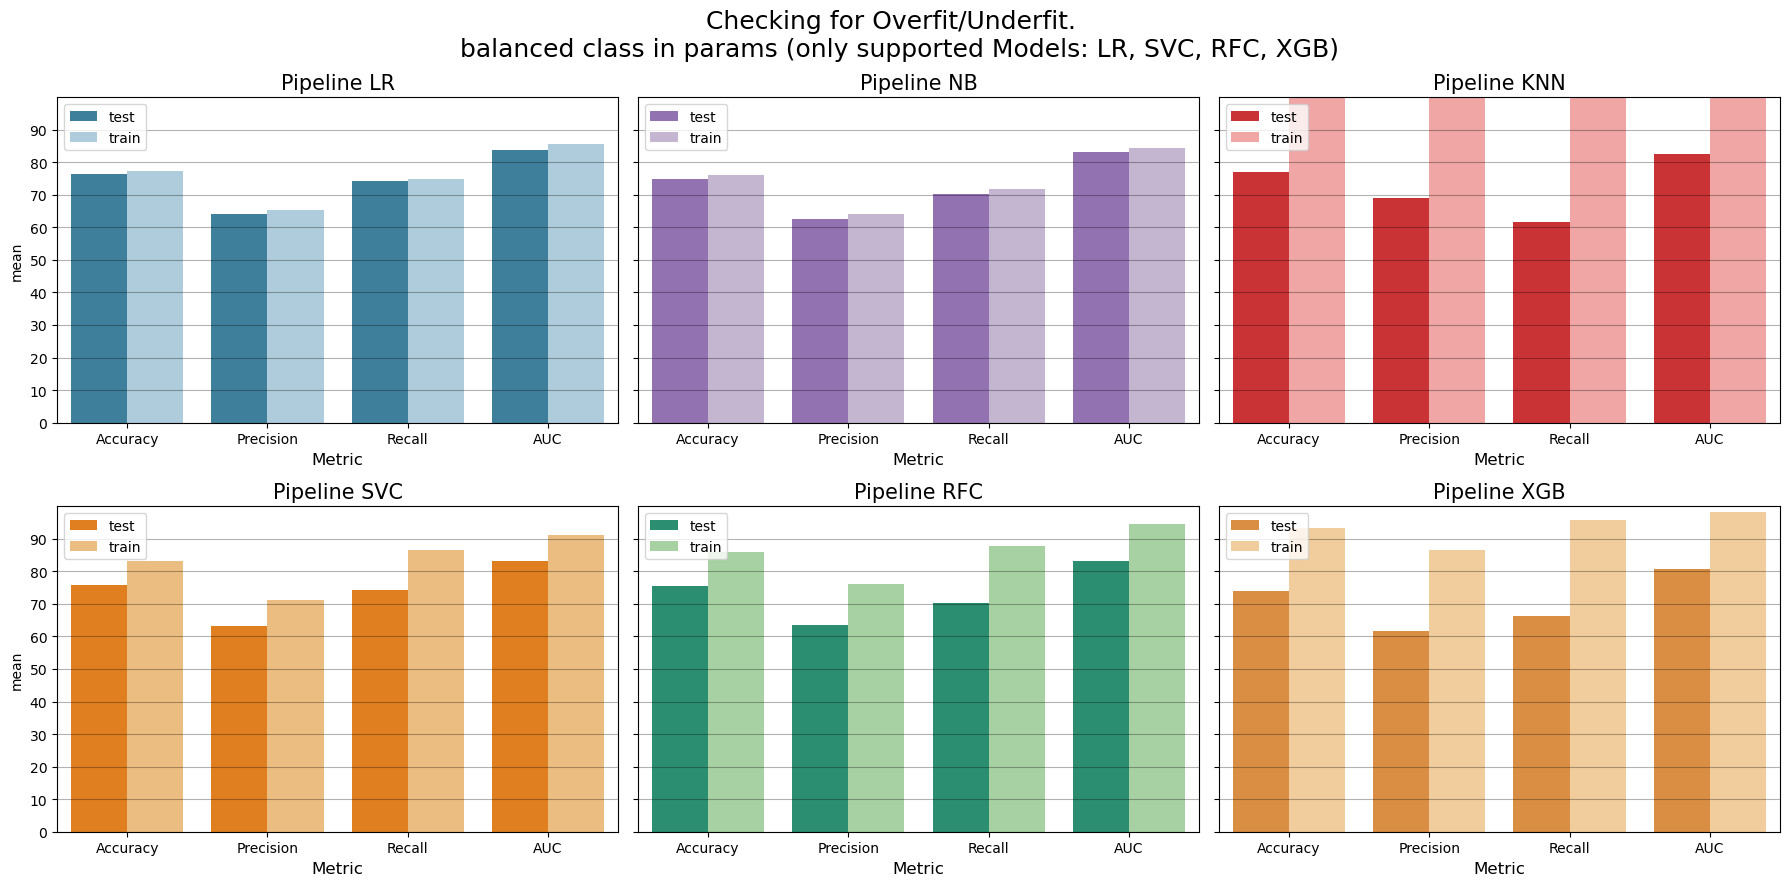

In [63]:
plot_overfitting_from_cv(df=cv_df_no_smote, title='balanced class in params (only supported Models: LR, SVC, RFC, XGB)',
                         save_path= 'Overfit check no smote.png')

More Gap between Train and Test = More overfit/underfit.  in our case No Model underfitted.    
Only Logistic Regression and Naive Bayes show nearly No Overfitting,  
Logistic Regression Shows better Performance with help of class_weight = 'balanced'

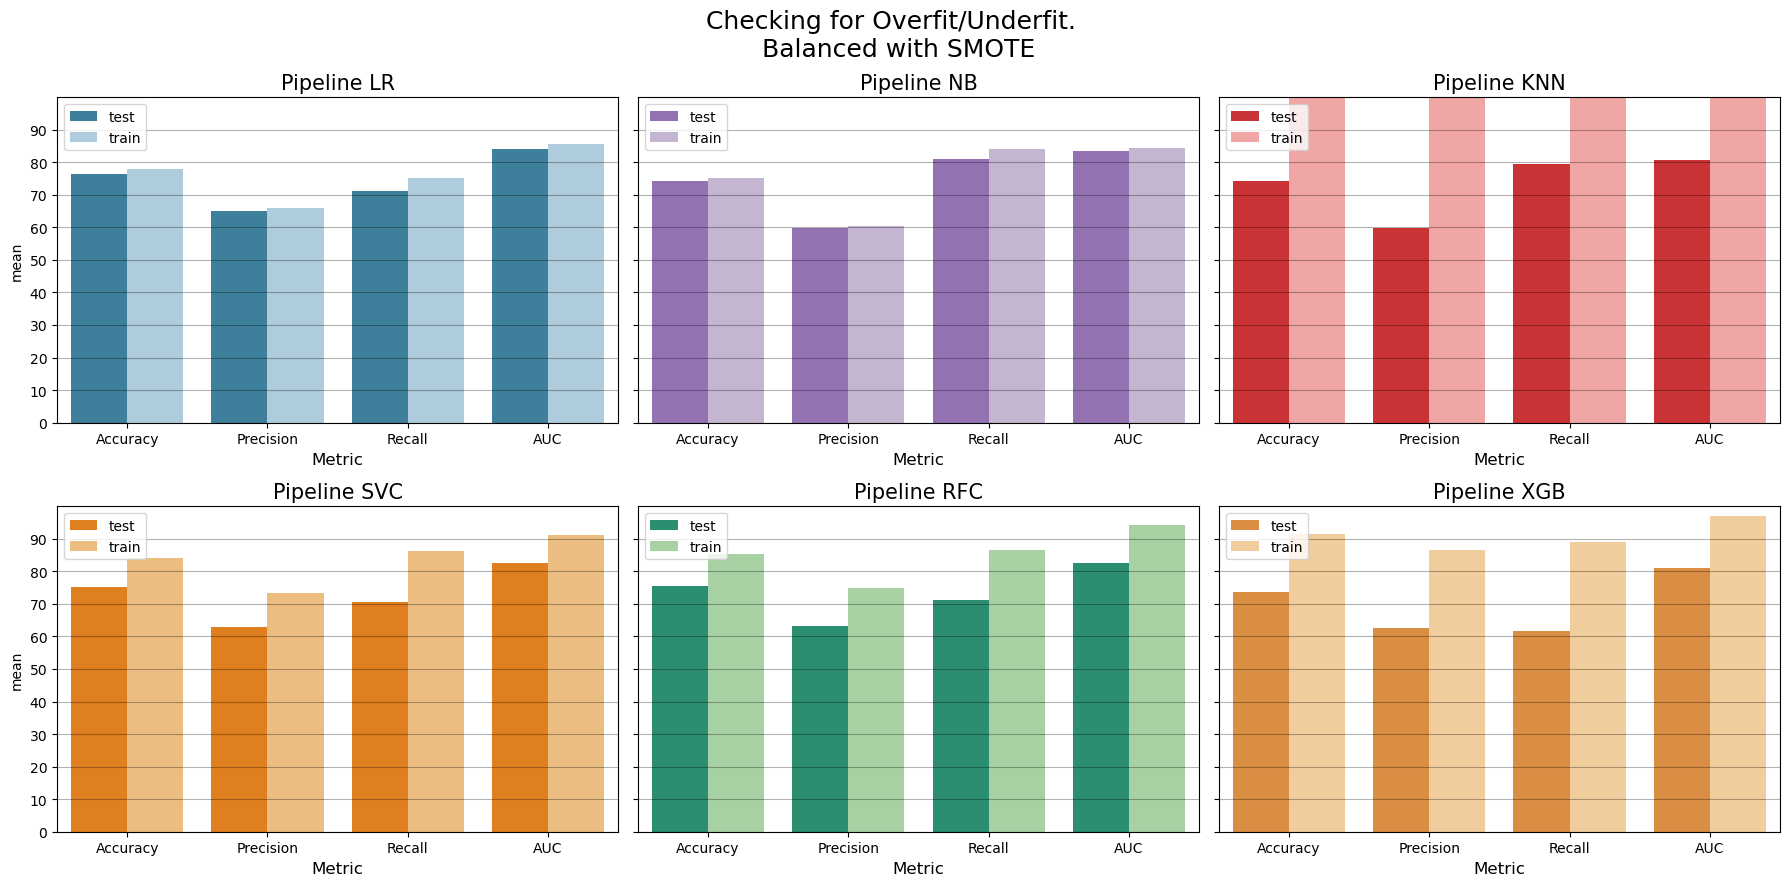

In [64]:
plot_overfitting_from_cv(df=cv_df_smote, title='Balanced with SMOTE',
                         save_path= 'Overfit check smote.png')

NB and KNN radically increased on recall but others not benefitted much from SMOTE.    
Overfitting is nearly the same as before in Non SMOTE and SMOTE    
still Best Options Are: Logistic Regression (no smote) and Naive Bayes (smote).  

#### Logistic Regression or Naive Bayes?

In [65]:
lr_score = cv_df_no_smote[cv_df_no_smote['Model'] == 'LR']
nb_score = cv_df_smote[cv_df_smote['Model'] == 'NB']

In [66]:
lr_score = lr_score[lr_score['Split'] == 'test']
nb_score = nb_score[nb_score['Split'] == 'test']

In [67]:
lr_nb = pd.concat([lr_score, nb_score]).sort_values('mean', ascending=False).drop('Split', axis=1).set_index('Model')

In [68]:
lr_nb

,Metric,mean,std
Model,,,
LR,AUC,83.91,0.03
NB,AUC,83.30,0.02
NB,Recall,81.12,0.06
LR,Accuracy,76.39,0.02
NB,Accuracy,74.31,0.02
LR,Recall,74.16,0.06
LR,Precision,64.01,0.03
NB,Precision,59.68,0.01


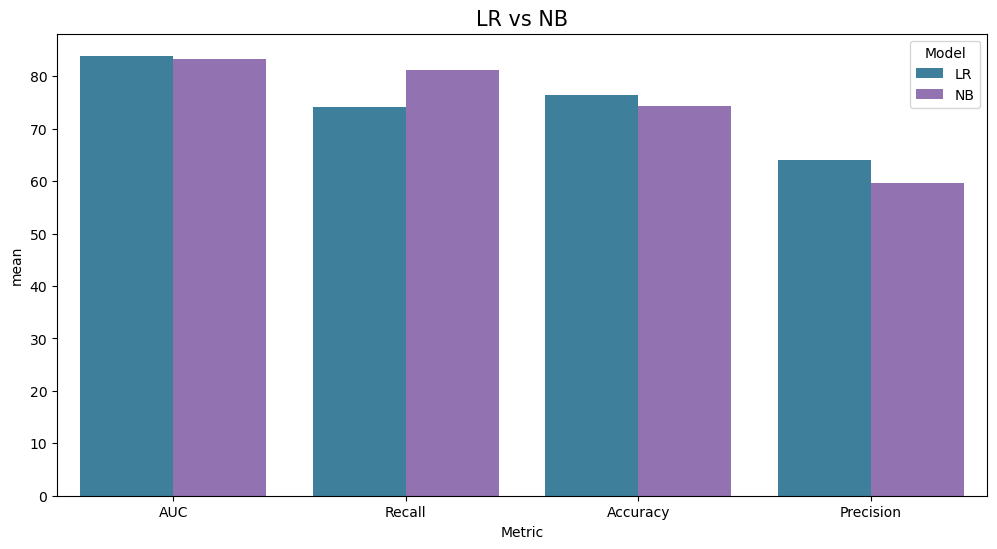

In [69]:
palette_lr_xg = ['#2E86AB', '#9467bd']

plt.figure(figsize=(12, 6))
plt.title('LR vs NB', fontsize=15)
sns.barplot(data=lr_nb,
            x='Metric',
            y='mean',
            hue='Model',
            palette=palette_lr_xg)
plt.savefig('LR vs NB.png')

we can go with NB for its higher recall score naively, but lets test them first.  

### TESTING
##### on Unseen Data

In [70]:
def evaluate_model(name, pipe, X_train, y_train, X_test, y_test, y_pred=None):
    
    pipe.fit(X_train, y_train)
    if y_pred is None:
        y_pred = pipe.predict(X_test)
    return {
            'Model'     : name.replace('pipeline_', '').upper(),
            'Accuracy'  : accuracy_score(y_test, y_pred),
            'Precision' : precision_score(y_test, y_pred),
            'Recall'    : recall_score(y_test, y_pred),
            'F1'        : f1_score(y_test, y_pred)
    }

##### Tune Model: NB

In [71]:
nb_default = Pipeline(steps=[                                   
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler' , StandardScaler()),
    ('model'  , GaussianNB())])

In [72]:
param_grid_nb = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_nb = GridSearchCV(nb_default, param_grid_nb, cv=cv, n_jobs=-1, scoring='roc_auc')

In [73]:
grid_nb.fit(X, y)          # Becouse the Dataset is small we use all of it each sample can add predictive value

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('model', GaussianNB())]),
             n_jobs=-1,
             param_grid={'model__var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06,
                                                  1e-05, 0.0001, 0.001]},
             scoring='roc_auc')

In [74]:
grid_nb.best_params_

{'model__var_smoothing': 1e-09}

the default value for Gaussian NB

##### Tune Model: Logistic Regression

In [75]:
lr_default = Pipeline(steps=[                                   
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler' , StandardScaler()),
    ('model'  , LogisticRegression(class_weight='balanced'))])

In [76]:
param_grid = [
    {
        'model__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
        'model__penalty': ['l2', None],
        'model__C': np.logspace(-4, 4, 20),
        'model__class_weight': ['balanced'],
        'model__max_iter': [500],
    },
    {
        'model__solver': ['liblinear'],
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-4, 4, 20),
        'model__class_weight': ['balanced'],
        'model__max_iter': [500],
    },
    {
        'model__solver': ['saga'],
        'model__penalty': ['l2', 'elasticnet', None],
        'model__C': np.logspace(-4, 4, 20),
        'model__l1_ratio': [0, 0.15, 0.5, 0.85],   
        'model__class_weight': ['balanced'],
        'model__max_iter': [500],
    },
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(lr_default, param_grid, cv=cv, n_jobs=-1, scoring='roc_auc')

In [77]:
grid_lr.fit(X, y)     

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid=[{'model__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.2742...
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'model__class_weight': ['balanced'],
                          'model__l1_ratio': [0, 0.15, 0.5, 0.85],
                          'model__max_iter': [500],
                          'model__penalty': ['l2', 'elasticnet', None],
                          'model__solver': ['saga']}],
             scoring='roc_auc')

In [78]:
grid_lr.best_params_

{'model__C': 0.08858667904100823,
 'model__class_weight': 'balanced',
 'model__l1_ratio': 0.85,
 'model__max_iter': 500,
 'model__penalty': 'elasticnet',
 'model__solver': 'saga'}

In [79]:
lr_tuned = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler' , StandardScaler()),
    ('model'  , LogisticRegression(
        C            = 0.08858667904100823,
        class_weight ='balanced',
        l1_ratio     = 0.85,
        max_iter     = 500,
        penalty      = 'elasticnet',
        solver       = 'saga',
    ))])

In [80]:
lr_tuned.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.08858667904100823,
                                    class_weight='balanced', l1_ratio=0.85,
                                    max_iter=500, penalty='elasticnet',
                                    solver='saga'))])

#### Results

In [81]:
nb_score_test = pd.DataFrame(evaluate_model('nb', grid_nb.best_estimator_, X_train, y_train, X_test, y_test), index=[0])
lr_score_test = pd.DataFrame(evaluate_model('lr', lr_tuned, X_train, y_train, X_test, y_test), index=[0])

In [82]:
evaluate_cross(grid_nb.best_estimator_, X_train, y_train, name=None, scoring=None, cv=5, return_train_score=False)
# NB

,Model,Split,Metric,mean,std
0,Model,test,Accuracy,74.83,0.02
1,Model,train,Accuracy,76.09,0.01
2,Model,test,Precision,62.46,0.02
3,Model,train,Precision,64.11,0.01
4,Model,test,Recall,70.17,0.04
5,Model,train,Recall,71.64,0.02
6,Model,test,AUC,83.29,0.03
7,Model,train,AUC,84.40,0.01


In [83]:
evaluate_cross(lr_tuned, X_train, y_train, name=None, scoring=None, cv=5, return_train_score=False)
# LR

,Model,Split,Metric,mean,std
0,Model,test,Accuracy,76.22,0.01
1,Model,train,Accuracy,77.04,0.01
2,Model,test,Precision,64.35,0.03
3,Model,train,Precision,65.31,0.01
4,Model,test,Recall,72.17,0.06
5,Model,train,Recall,73.01,0.02
6,Model,test,AUC,83.80,0.03
7,Model,train,AUC,85.39,0.01


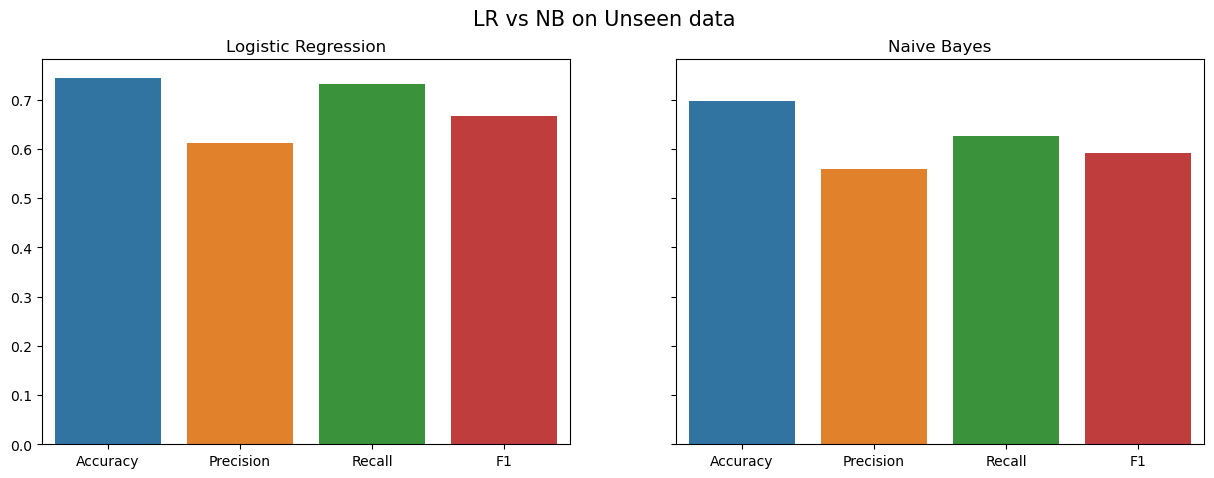

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
plt.suptitle('LR vs NB on Unseen data', fontsize=15)

ax[0].set_title('Logistic Regression')
sns.barplot(data=lr_score_test,  ax=ax[0])
ax[1].set_title('Naive Bayes')
sns.barplot(data=nb_score_test,  ax=ax[1])

plt.savefig('LR vs NB on Unseen Data.png')
plt.show()

Logistic Regression is the winner being Better Predictor Than Naive Bayes.  

#### tuning Threshold
##### to maximize f1 score

In [85]:
lr_score_test

,Model,Accuracy,Precision,Recall,F1
0,LR,0.744792,0.6125,0.731343,0.666667


In [86]:
y_proba    = lr_tuned.predict_proba(X_test)[:, 1]
thresholds = np.arange(.0, 1, 0.01)
f1s        = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
best_t     = thresholds[np.argmax(f1s)]
print(f'Best threshold: {best_t:.2f} -> F1 = {max(f1s):.3f}')

Best threshold: 0.30 -> F1 = 0.700


In [87]:
threshold = 0.3

y_pred_new = (y_proba >= threshold).astype(int)
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.95      0.60      0.74       125
           1       0.56      0.94      0.70        67

    accuracy                           0.72       192
   macro avg       0.75      0.77      0.72       192
weighted avg       0.81      0.72      0.72       192



This gives us the best Possible f1 score but it doesn't worth it !  
because this shows completely unbalanced scores:  
For Negative Diagnosis precision is 95% and recall is 60% the Gap is too much   
same for Positive diagnosis precision is 56% and recall is 94% !!!   
we will Adjust the threshold.

In [88]:
threshold = 0.5 # sweet spot!

y_pred_new = (y_proba >= threshold).astype(int)
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       125
           1       0.61      0.73      0.67        67

    accuracy                           0.74       192
   macro avg       0.73      0.74      0.73       192
weighted avg       0.76      0.74      0.75       192



Since the default threshold is the same we don't need to apply it.

###### for setting manual threshold

In [89]:
class ThresholdPipeline(BaseEstimator, ClassifierMixin):
    def __init__(self, pipeline, threshold=0.5):
        self.pipeline = pipeline
        self.threshold = threshold
    
    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self
    
    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)
    
    def predict(self, X):
        proba = self.pipeline.predict_proba(X)[:, 1]      # probability of positive class
        return (proba >= self.threshold).astype(int)

In [90]:
model = ThresholdPipeline(lr_pipeline, threshold=3.0)

NameError: name 'lr_pipeline' is not defined

#### Feature Importances

In [ ]:
perm_importance = permutation_importance(lr_tuned, X_test, y_test, n_repeats=10, random_state=42)

importances_df  = pd.DataFrame({
    'features'  : X.columns,
    'importance': perm_importance.importances_mean}).sort_values('importance', ascending=False)

In [ ]:
importances_df

In [ ]:
sns.barplot(data=importances_df,
            x='importance',
            y='features')

plt.savefig('feature_importances.png')
plt.show()

Glucose is the Best Predictor of Diabetes by far.  
followed by BMI, Pregnancies, DiabetesPedigreeFunction and Age   

Some Features are Exactly Zero they can even be Below zero:  
If a feature does not contribute significantly to the model's predictive power, model may assign it a coefficient of zero.  
This indicates that the feature is not useful for the prediction.

#### Save The Model

In [ ]:
lr_tuned.fit(X, y)

In [ ]:
joblib.dump(lr_tuned, 'lr_final_for_diabetes.joblib')